In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys


from science_jubilee import Machine as Jub
from science_jubilee.labware.Labware import Labware, Well
from science_jubilee.tools import Pipette, WebCamera, Tool
import science_jubilee.labware.Labware as ll

# import color_match
# from color_match import BO_campaign
# import jubilee_protocols
import ipywidgets as widgets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from math import sqrt, acos, asin, cos, sin
import copy

In [50]:
jubilee = Jub.Machine(address='192.168.1.2')

In [4]:
jubilee.home_all()

In [51]:
deck = jubilee.load_deck('lab_automation_deck.json')

In [52]:
tiprack = jubilee.load_labware('opentrons_96_tiprack_300ul.json', 0, order='row')
samples = jubilee.load_labware('corning_96_wellplate_360ul_flat.json', 2, order = 'row')
stocks = jubilee.load_labware('20mlscintillation_12_wellplate_18000ul.json', 3, order = 'row')
#trash = jubilee.load_labware('agilent_1_reservoir_290ml.json', 1)

In [53]:
P300 = Pipette.Pipette.from_config(1, 'Pipette', 'P300_config.json')
jubilee.load_tool(P300)
P300.add_tiprack(tiprack)

In [54]:
Camera = WebCamera.Camera.from_config(0, 'Camera', 'WebCamera_config.json')
jubilee.load_tool(Camera)

In [55]:
# Move the plate down to load all necessary labware
jubilee.move_to(z=115)

### Let's calibrate the labware first

Pickup the pipette, calibrate the tiprack, then pickup a tip and use it to calibrate the location of the labware using the 3D printed well_centroid parts for an easier experience. This can also be done using a Camera tool.

In [56]:
UL = [30.0,79.0]
UR = [129.0, 79.4]
BR = [129.5, 16.9]

tiprack.manual_offset((UL, UR, BR), save = True) #, save=True, force=True)

Labware already has a manual offset found for this slot. If you want to overwrite it, set save=True
New manual offset applied to opentrons_96_tiprack_300ul
stored manual offset found.  To overwrite it on the `config.json` file, set force=True


In [57]:
UL = [32.3,176.4]
UR = [123.4, 176.9]
BR = [123.7, 112.6]

samples.manual_offset((UL, UR, BR), save=True)

New manual offset applied to corning_96_wellplate_360ul_flat
Manual offset saved


In [58]:
UL = [175.5, 171.5]
UR = [259.3, 172.1]
BR = [259.9, 117.0]

stocks.manual_offset((UL, UR, BR), save=True)

Labware already has a manual offset found for this slot. If you want to overwrite it, set save=True
New manual offset applied to 20mlscintillation_12_wellplate_18000ul
stored manual offset found.  To overwrite it on the `config.json` file, set force=True


In [59]:
jubilee.pickup_tool(Camera)

In [66]:

well_image = Camera.capture_image(samples['A1'], light=False, light_intensity =0.5)
rgb_values= Camera.process_image(well_image)
print(rgb_values)

swapping
[182.72326322498407, 146.10439770554493, 98.56290630975144]


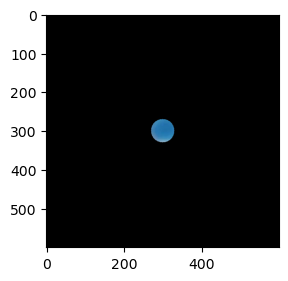

In [68]:
Camera.view_image(well_image, masked=True, radius = 30)

In [ ]:
jubilee.park_tool()

## Color Picking

In [18]:
a = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

In [19]:
a

ColorPicker(value='blue', description='Pick a color')

In [20]:
hexcode = a.value
target_rgb = tuple(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0,2,4))
target_rgb

(188, 131, 226)

## Set Up for Demo

In [21]:
red_stock = stocks[2]
yellow_stock = stocks[1]
blue_stock = stocks[0]
trash_well = trash[0]

## Get Initial Data

In [22]:
sample_space = color_match.get_constrained_points(101)

In [24]:
n_init_points = 3
sampled_indices = np.random.randint(0, len(sample_space), size = n_init_points)
sampled_points = sample_space[sampled_indices]

In [30]:
P300.return_tip()

In [31]:
jubilee.park_tool()

In [32]:
jubilee.pickup_tool(Camera)

In [33]:
Camera.capture_image(samples[0])

TypeError: catching classes that do not inherit from BaseException is not allowed

In [34]:
jubilee.park_tool()

In [29]:
rgb_vals = []
for i in range(len(sampled_points)):
    point = sampled_points[i,:]
    well = samples[i]
    print('creating sample')
    print(point)
    print(well)
    
    RGB = jubilee_protocols.sample_point(jubilee, P300, Camera, point, 500, well, red_stock, yellow_stock, blue_stock, trash_well)
    rgb_vals.append(RGB)

creating sample
[0.03 0.11 0.86]
Well(name='A1', depth=17.78, totalLiquidVolume=1500, shape='circular', diameter=10.38, xDimension=None, yDimension=None, x=174.6, y=175.97, z=2.41, offset=[155.7, 100.0])
Start of sample sequence position:  {'X': '47.580', 'Y': '79.040', 'Z': '151.830', 'U': '0.000', 'V': '310.000', 'E': '0.000'}
Calculated volumes:  [15.0, 55.0, 430.0]


TypeError: 'Location' object is not subscriptable

In [38]:
# jubilee.pickup_tool(P300)
P300.pickup_tip() # since we associated a tiprack with the pipette, no need to specify a tip 

Connection error, sleeping 1 second


In [38]:
P300.return_tip()

In [ ]:
P300.aspirate(200, well= stocks['A1'])
P300.dispense(200, well= samples[0]) # you can either specify a well name or index

P300.return_tip()# this will drop the tip from the location it picked it up from
# OR
P300.drop_tip(trash[0]) # this will eject the tip in the specified location

In [40]:
jubilee.park_tool()

In [ ]:
jubilee.pickup_tool(Camera)
well_image = Camera.capture_image(samples['A1'])
rgb_values= Camera.process_image(well_image)
print(rgb_values)

In [17]:
jubilee.park_tool()